In [1]:
cd /Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/

/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs


/Users/karolinegriesbach/.local/share/virtualenvs/consumption-based-costs-wGvc2ut4/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import re
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from src.utils.accounts import sanitize_account_name
from src.utils.innkeepr_api import call_api_with_service_token, send_to_innkeepr_api_paginated
from src.utils.constants import return_api_url_innkeepr
from src.utils.github_connection import read_yaml_from_github
from src.utils.databricks_pp import handle_databricks_cost
from src.utils.azure_pp import handle_azure_costs
from src.utils.aws_pp import handle_aws_costs
from src.utils.stackit_pp import stack_pp
from src.utils.cost_handling import return_cost_per_run

# Define Variables

In [3]:
from_date = "2024-01-01"
to_date="2025-06-23"
timestamp = "2025-06-23 13:23:56.520433"
path_to_dir = f"/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/data/{from_date}_to_{to_date}/{timestamp}/"
path_to_data=f"{path_to_dir}final_costs_with_azure_and_aws_and_db_{from_date}_{to_date}.csv"
path_to_save = f"/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/data/{from_date}_to_{to_date}/targeting_and_retraining/"
url = return_api_url_innkeepr()
stackit_cost_handling = {
    # "start": "2024-11-11",
    "exlude_date_ranges": [
        {
            "start": "2024-12-22",
            "end" : "2025-01-03",
        }
    ],
    "start":"2025-02-09" # davor keine eindeutige Kostenzuordnung zw. azure und stackit möglich in den Zeitspannen: 12.11.24 - 19.11.24, 20.12.24-21.12.24, 04.01.25-06.01.25, 10.01.25-12.01.25, 07.02.25 - 08.02.25
}

In [4]:
os.makedirs(path_to_save, exist_ok=True)

# Load Data

In [5]:
df_orignal = pd.read_csv(path_to_data)
df_orignal = df_orignal[[col for col in df_orignal.columns if "Unnamed" not in col]]
df_orignal

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_14065/2663018799.py:1: DtypeWarning: Columns (4,5,6,7,8,9,11,12,13,14,15,17,18,19,20,22,23,24,27,28,31,38,39,40,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orignal = pd.read_csv(path_to_data)


,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.188056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,retraining,asambeauty,16cpu256gib,6687daf21767991e3bdfb414,16 2 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-16 00:36:36.760786,...,18.846250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.068611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.632778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
139519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
139520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
139521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN


In [6]:
df = stack_pp(df_orignal)

Service: General Purpose Server-g1.4-EU01
Service: General Purpose Server-g1.1-EU01
Service: Compute Optimized Server-c1.2-EU01
Service: Tiny Server-t1.2-EU01


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139523 entries, 0 to 139522
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Deployments                     17623 non-null   object 
 1   tenant                          34498 non-null   object 
 2   deployment_node_name            7083 non-null    object 
 3   audience                        12210 non-null   object 
 4   schedule                        12210 non-null   object 
 5   use_conversion_table_targeting  9335 non-null    object 
 6   max_model_age_in_days           1670 non-null    float64
 7   node_retraining_reset           807 non-null     object 
 8   Prefect_Deployments             37566 non-null   object 
 9   timestamp                       36919 non-null   object 
 10  audience_id                     28318 non-null   object 
 11  account                         36919 non-null   object 
 12  duration        

In [8]:
df["Prefect_Deployments"] = df["Prefect_Deployments"].replace("retrainng", "retraining")
df["Prefect_Deployments"].value_counts()

Prefect_Deployments
targeting                       24102
etlFlow                          6165
retraining                       4091
genPropConversionTable           1845
stackit_default_servers           787
updateConversionTable             450
googleConversionUpdate            120
TEST-googleConversionUpdate         3
TEST-k8-targeting                   2
TEST-update-conversion-table        1
Name: count, dtype: int64

# Filter Data
Filter data for targeting runs only using Deployments and Prefect_Deployments. Valid strings are:

- targeting
- retraining
- googleConversionUpdate (smart bidding)

In [9]:
# get stackIT costs via Prefect_Deployments
targeting_and_retraining_runs = df[(df["Prefect_Deployments"].isnull()==False)]#df[(df["Deployments"]=="targeting")|(df["Prefect_Deployments"]=="targeting")|(df["Deployments"]=="retraining")|(df["Prefect_Deployments"]=="retraining")|(df["Deployments"]=="googleConversionUpdate")|(df["Prefect_Deployments"]=="googleConversionUpdate")]
# Bug in cost extractor: "retrainng" instead of "retraining" (behoben)
targeting_and_retraining_runs

,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
1,retraining,asambeauty,16cpu256gib,6687daf21767991e3bdfb414,16 2 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-16 00:36:36.760786,...,18.846250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,retraining,asambeauty,16cpu256gib,6687da6e1767991e3bdfa9d8,15 5 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-22 03:35:35.979026,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,retraining,asambeauty,16cpu256gib,670509c46b67f0eede5ea371,56 3 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-22 04:22:50.831826,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,retraining,asambeauty,16cpu256gib,6617da9c01c2ab3bd12c63cb,47 3 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-23 02:39:15.536370,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,retraining,asambeauty,16cpu256gib,6687da6e1767991e3bdfa9d8,15 5 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-23 03:38:28.244593,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-25 12:14:37.767248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-25 12:13:52.247539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,genPropConversionTable,2025-05-25 14:03:16.660279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-26 07:03:15.630586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
targeting_and_retraining_runs["Prefect_Deployments"].value_counts(dropna=False)

Prefect_Deployments
targeting                       24102
etlFlow                          6165
retraining                       4091
genPropConversionTable           1845
stackit_default_servers           787
updateConversionTable             450
googleConversionUpdate            120
TEST-googleConversionUpdate         3
TEST-k8-targeting                   2
TEST-update-conversion-table        1
Name: count, dtype: int64

# Historical count of targeting runs and prefect runs

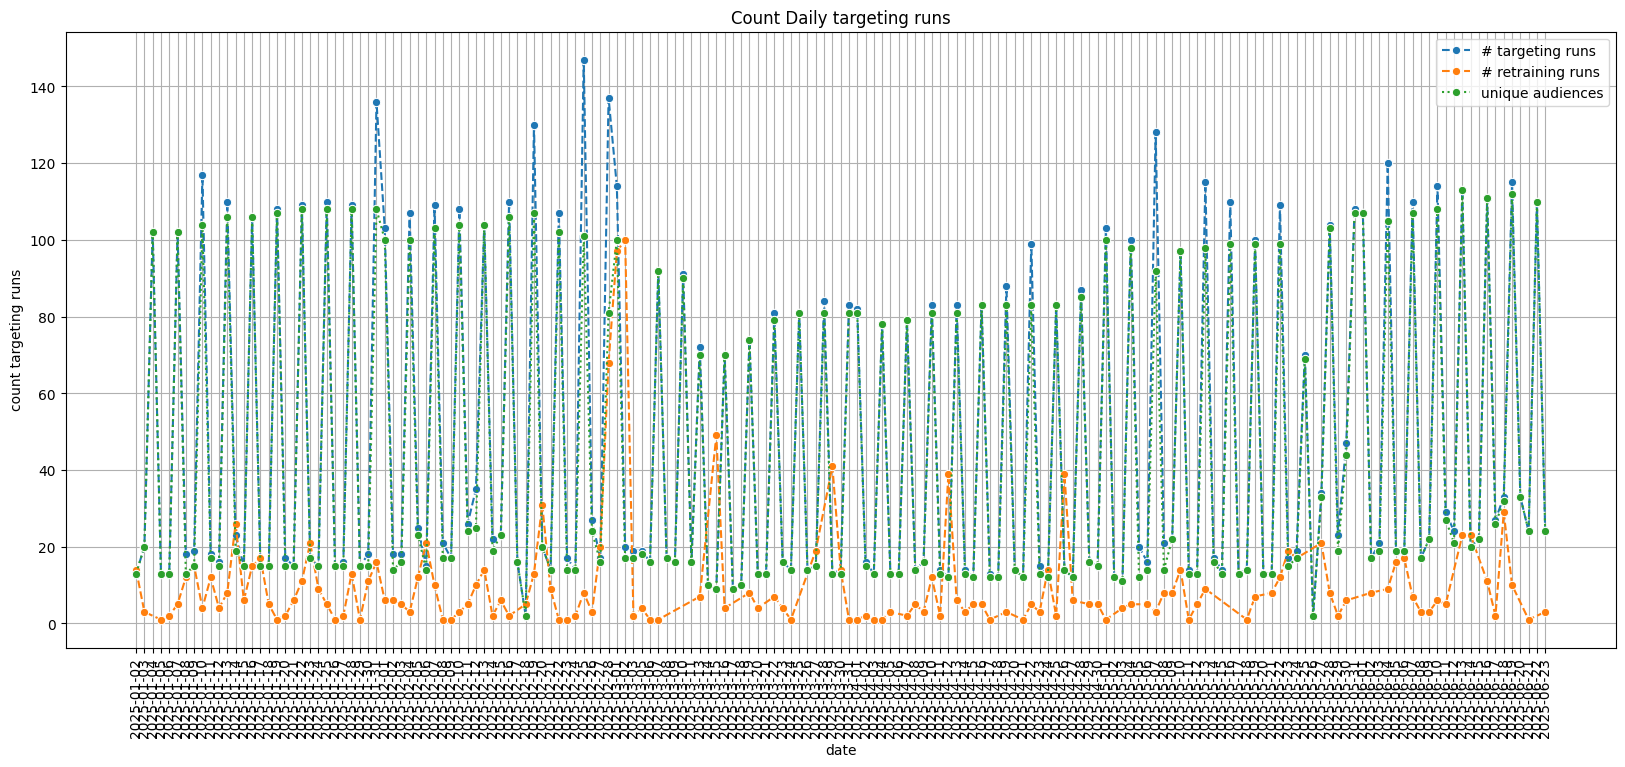

In [11]:
targeting_runs = targeting_and_retraining_runs[targeting_and_retraining_runs["Prefect_Deployments"]=="targeting"]
retraining_runs = targeting_and_retraining_runs[targeting_and_retraining_runs["Prefect_Deployments"]=="retraining"]
runs_vc_by_date = targeting_runs.groupby("date")["Prefect_Deployments"].value_counts()
runs_vc_by_date = pd.DataFrame(runs_vc_by_date).reset_index().rename(columns={"count":"count targeting runs"})
runs_vc_by_date_retraining = retraining_runs.groupby("date")["Prefect_Deployments"].value_counts()
runs_vc_by_date_retraining = pd.DataFrame(runs_vc_by_date_retraining).reset_index().rename(columns={"count":"count retraining runs"})
audiences_unique_by_date = targeting_runs.groupby("date")["audience_id"].nunique()
audiences_unique_by_date = pd.DataFrame(audiences_unique_by_date).reset_index()
concat = pd.merge(runs_vc_by_date, audiences_unique_by_date, on="date")
fig = plt.figure(figsize=(20,8))
sns.lineplot(
    x="date",
    y="count targeting runs",
    data=runs_vc_by_date[runs_vc_by_date["date"] > "2025-01-01"],
    marker="o",
    linestyle="--",
    label="# targeting runs"
)
sns.lineplot(
    x="date",
    y="count retraining runs",
    data=runs_vc_by_date_retraining[runs_vc_by_date_retraining["date"] > "2025-01-01"],
    marker="o",
    linestyle="--",
    label="# retraining runs"
)
sns.lineplot(
    x="date",
    y="audience_id",
    data=audiences_unique_by_date[audiences_unique_by_date["date"] > "2025-01-01"],
    marker="o",
    linestyle=":",
    label="unique audiences"
)
plt.title("Count Daily targeting runs")
plt.xticks(rotation=90)
plt.grid(True)

# Check Data Completion for node types, date and costs

In [12]:
print(len(targeting_and_retraining_runs))
null_values = targeting_and_retraining_runs[["node_name","date","charge","machine.type","audience_id","duration","total_charge_of_serviceName","audience"]].isnull().sum()
null_values = pd.DataFrame(null_values).rename(columns={0:"isnull"})
null_values["percentage_of_isnull"] = null_values["isnull"]/len(targeting_and_retraining_runs) * 100
null_values.sort_values(by="isnull")

37566


,isnull,percentage_of_isnull
date,0,0.000000
duration,647,1.722302
audience_id,9248,24.618006
audience,25356,67.497205
node_name,27765,73.909919
charge,30756,81.871905
total_charge_of_serviceName,30756,81.871905
machine.type,31364,83.490390


## Handling Missing Data
- fehlend node_names mit existing node_names anreichern via targeting and retraining audience
- fehlende Kosten über node_names und runtime anreichern
- charges per targeting run erst ab dm 26.05.2025 via prefect_logs


## Query models for all active accounts
All past models are queried for the existing tenants in the dataset. 

In [13]:
# query models to map audience node_name with targetingOutlook (is one of the main parameter to choose the node size)
try:
    models = pd.read_csv(f"{path_to_save}all_models.csv")
    with open(f"{path_to_save}ignore_tenants.json", "r") as f:
        ignore_tenants = json.load(f)
except FileNotFoundError:
    print("query data")
    models=pd.DataFrame()
    #min_date = targeting_and_retraining_runs["date"].min()
    #min_date = (pd.to_datetime(min_date)-timedelta(days=60)).strftime("%Y-%m-%d")
    ignore_tenants = []
    accounts = call_api_with_service_token(f"{url}/core/accounts/query", {}, logging)
    for tenant in targeting_and_retraining_runs["tenant"].unique():
        print(tenant)
        account_id = [acc["id"] for acc in accounts if sanitize_account_name(acc["name"])==tenant]
        if len(account_id) > 1:
            raise Exception(f"More than one account with name {tenant}")
        if len(account_id) == 0:
            print(f"Tenant {tenant} not found in accounts")
            ignore_tenants.append(tenant)
            continue
        account_id = account_id[0]
        temp_models = send_to_innkeepr_api_paginated(
            f"{url}/models/query",
            account_id,
            {},
            logging
        )
        temp_models = pd.json_normalize(temp_models)
        if len(temp_models) == 0:
            print(f"No models found for tenant {tenant}")
            ignore_tenants.append(tenant)
            continue
        #temp_models = temp_models[temp_models["created"]>=min_date]
        models = pd.concat([models, temp_models])
    print(models.shape)
    missing_audiences = targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]
    missing_audiences = missing_audiences[missing_audiences["audience_id"].isin(models["audience"].unique())==False]
    if missing_audiences.empty == False:
        print(f"Missing {len(missing_audiences)} models")
        print(missing_audiences[["tenant","audience_id"]].drop_duplicates())
    models.to_csv(f"{path_to_save}all_models.csv")
    with open(f"{path_to_save}ignore_tenants.json", "w") as f:
        json.dump(list(ignore_tenants), f)
models

,Unnamed: 0,id,created,path,audience,treatment,goal,targetingOutlookDays,trainingOutlookDays,f1Score,audienceSizePercentage,treatmentSessionCount,type,audienceSize,outlook,conversionLag,manualRetrainReason
0,0,66a4676ddc89c1900b14b906,2024-07-27T03:20:13.127Z,asambeauty-aud-65c0f44bf2e2b9b5a9bab145/2024-0...,65c0f44bf2e2b9b5a9bab145,"['65b1b4eed3c557379810c8c2', '65b1b4eed3c55737...",65ae65e92989649becfd8cf6,23.0,NaN,0.55,NaN,127724.0,causal,150000.0,NaN,NaN,NaN
1,1,66a981af7b71545fb02be286,2024-07-31T00:13:35.669Z,asambeauty-conversion-65ae65e92989649becfd8cf6...,668d44dc1767991e3b3c3fef,[],65ae65e92989649becfd8cf6,90.0,NaN,0.82,NaN,11455.0,conversion,150000.0,NaN,NaN,NaN
2,2,66ad8e53104f9bacb5495ce8,2024-08-03T01:56:35.836Z,asambeauty-conversion-65ae65e92989649becfd8cf6...,6617a6ed01c2ab3bd127f8c5,[],65ae65e92989649becfd8cf6,90.0,NaN,0.84,NaN,0.0,conversion,150000.0,NaN,NaN,NaN
3,3,66b57753b599ea1467b95c75,2024-08-09T01:56:35.572Z,asambeauty-conversion-65ae65e92989649becfd8cf6...,6617a6ed01c2ab3bd127f8c5,[],65ae65e92989649becfd8cf6,90.0,NaN,0.84,NaN,0.0,conversion,150000.0,NaN,NaN,NaN
4,4,67243467f54847c02c17bb4d,2024-11-01T01:52:39.656Z,asambeauty-aud-66c5f8db781b51d399748172/2024-1...,66c5f8db781b51d399748172,"['65b1b4eed3c557379810c8e5', '65b1b4eed3c55737...",65ae65e92989649becfd8cf6,30.0,NaN,0.74,0.5,77994.0,causal,150000.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5619,291,67c3c27e640e06a4e707e607,2025-03-02T02:29:18.603Z,paulvalentine-conversion-669d6580c77d9922edbfa...,66be1d01781b51d399a63d36,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,180.0,NaN
5620,292,67c3c8687650bd81c3e8a327,2025-03-02T02:54:31.959Z,paulvalentine-conversion-669d6580c77d9922edbfa...,670921946b67f0eeded38450,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
5621,293,67c3ca4360c56cf0da9b3114,2025-03-02T03:02:26.930Z,paulvalentine-conversion-669d6580c77d9922edbfa...,66be1d6f781b51d399a64995,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
5622,294,67c3d26c640e06a4e707e60a,2025-03-02T03:37:16.087Z,paulvalentine-conversion-669d6580c77d9922edbfa...,67a4c6e9e9a9d2ef0b863db4,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,180.0,NaN


In [14]:
audiences_in_models_but_not_in_targeting_runs = models[
    (models["audience"].isin(targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]["audience_id"].unique())==False) &
    (models["created"]>=targeting_runs["date"].min())
    ]
if audiences_in_models_but_not_in_targeting_runs.empty == False:
    print(f"Found {len(audiences_in_models_but_not_in_targeting_runs)} models that are not in the targeting runs")
    raise Exception(audiences_in_models_but_not_in_targeting_runs[["audience","path","created"]])

Found 3 models that are not in the targeting runs


Exception:                       audience  \
1591  65fb0acf15c25acc11bebf44   
1634  65fb0a7c15c25acc11beb553   
1997  65fb0b0b15c25acc11bec741   

                                                   path  \
1591  rosental-conversion-63e61e29bfc19074664d8a32/2...   
1634  rosental-conversion-63e61e29bfc19074664d8a32/2...   
1997  rosental-conversion-63e61e29bfc19074664d8a32/2...   

                       created  
1591  2024-03-21T05:14:01.146Z  
1634  2024-03-21T02:55:02.651Z  
1997  2024-03-21T04:31:57.849Z  

## Merge Models and Targeting Runs by considering date and targetingOutlookDays

In [15]:
models = models[["audience","created","targetingOutlookDays"]]
models.head()

,audience,created,targetingOutlookDays
0,65c0f44bf2e2b9b5a9bab145,2024-07-27T03:20:13.127Z,23.0
1,668d44dc1767991e3b3c3fef,2024-07-31T00:13:35.669Z,90.0
2,6617a6ed01c2ab3bd127f8c5,2024-08-03T01:56:35.836Z,90.0
3,6617a6ed01c2ab3bd127f8c5,2024-08-09T01:56:35.572Z,90.0
4,66c5f8db781b51d399748172,2024-11-01T01:52:39.656Z,30.0


In [16]:
targeting_and_retraining_runs["tenant"] = np.where(
    targeting_and_retraining_runs["tenant"].isnull(),
    targeting_and_retraining_runs["account"].str.replace(" ","").str.lower(),
    targeting_and_retraining_runs["tenant"]
)

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_14065/838350266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeting_and_retraining_runs["tenant"] = np.where(


In [17]:
models = models.rename(columns={"audience":"audience_id","created":"created_data_model_for_testing"})
# Filter data_model_for_testing to get the most recent model for each audience before the date in data_for_testing
print(f"targeting_and_retraining_runs = {len(targeting_and_retraining_runs)}")
merged_targeting_runs_with_models = pd.merge(targeting_and_retraining_runs, models, on=['audience_id'], how="left")#suffixes=('_data_for_testing', '_data_model_for_testing'))
# macht data where the model.created < data.timestamp
merged_targeting_runs_with_models_with_previous_models = merged_targeting_runs_with_models[pd.to_datetime(merged_targeting_runs_with_models['created_data_model_for_testing'],utc=True) <= pd.to_datetime(merged_targeting_runs_with_models['timestamp'],utc=True)]
merged_targeting_runs_with_models_with_previous_models = merged_targeting_runs_with_models_with_previous_models.sort_values(by='created_data_model_for_testing', ascending=False).drop_duplicates(subset=['Prefect_Deployments','tenant','audience_id','timestamp','node_name'], keep='first')
print(f"merged_targeting_runs_with_models_with_previous_models = {len(merged_targeting_runs_with_models_with_previous_models)}")
vc_with_previous_model = merged_targeting_runs_with_models_with_previous_models["Prefect_Deployments"].value_counts(dropna=False).astype("int")
vc_with_previous_model = vc_with_previous_model.reset_index().rename(columns={"count":"count_with_prev_model"})

# get data where data.timestamp does not have a matching model
merged_targeting_runs_with_models_without_previous_models = models.groupby("audience_id")["created_data_model_for_testing"].min()
merged_targeting_runs_with_models_without_previous_models = pd.DataFrame(merged_targeting_runs_with_models_without_previous_models).reset_index()
merged_targeting_runs_with_models_without_previous_models = pd.merge(targeting_and_retraining_runs, merged_targeting_runs_with_models_without_previous_models, on="audience_id")
merged_targeting_runs_with_models_without_previous_models = merged_targeting_runs_with_models_without_previous_models[pd.to_datetime(merged_targeting_runs_with_models_without_previous_models['timestamp'],utc=True) <= pd.to_datetime(merged_targeting_runs_with_models_without_previous_models['created_data_model_for_testing'],utc=True)]
print(f"merged_targeting_runs_with_models_without_previous_models = {len(merged_targeting_runs_with_models_without_previous_models)}")
vc_without_previous_model = merged_targeting_runs_with_models_without_previous_models["Prefect_Deployments"].value_counts(dropna=False).astype("int")
vc_without_previous_model = vc_without_previous_model.reset_index().rename(columns={"count":"count_without_prev_model"})

# get data with null models
considered_audiences = merged_targeting_runs_with_models_with_previous_models["audience_id"].unique().tolist() + merged_targeting_runs_with_models_without_previous_models["audience_id"].unique().tolist()
merged_targeting_runs_with_models_null_models = merged_targeting_runs_with_models[
    (merged_targeting_runs_with_models["audience_id"].isin(considered_audiences) == False)]
merged_targeting_runs_with_models_null_models = merged_targeting_runs_with_models_null_models[merged_targeting_runs_with_models_null_models["tenant"].isin(ignore_tenants)==False]
print(f"merged_targeting_runs_with_models_null_models = {len(merged_targeting_runs_with_models_null_models)}")
vc_null_model = merged_targeting_runs_with_models_null_models["Prefect_Deployments"].value_counts(dropna=False).astype("int")
vc_null_model = vc_null_model.reset_index().rename(columns={"count":"count_null_model"})

# concate data
merged_targeting_runs_with_models = pd.concat([merged_targeting_runs_with_models_with_previous_models, merged_targeting_runs_with_models_without_previous_models,merged_targeting_runs_with_models_null_models])
merged_targeting_runs_with_models = merged_targeting_runs_with_models.reset_index(drop=True)

targeting_and_retraining_runs = 37566
merged_targeting_runs_with_models_with_previous_models = 33003
merged_targeting_runs_with_models_without_previous_models = 95
merged_targeting_runs_with_models_null_models = 4


In [18]:
vc_original = targeting_and_retraining_runs["Prefect_Deployments"].value_counts(dropna=False).astype("int")
vc_original = vc_original.reset_index().rename(columns={"count":"count_original"})
vc_original_ignore_tenants = targeting_and_retraining_runs[targeting_and_retraining_runs["tenant"].isin(ignore_tenants)==False]["Prefect_Deployments"].value_counts(dropna=False).astype("int")
vc_original_ignore_tenants = vc_original_ignore_tenants.reset_index().rename(columns={"count":"count_original_ignore_tenants"})
vc_merged = pd.merge(vc_original, vc_with_previous_model, on="Prefect_Deployments", how="left")
vc_merged = pd.merge(vc_merged, vc_without_previous_model, on="Prefect_Deployments", how="left")
vc_merged = pd.merge(vc_merged, vc_null_model, on="Prefect_Deployments", how="left")
vc_merged = pd.merge(vc_merged, vc_original_ignore_tenants, on="Prefect_Deployments", how="left")
vc_merged["sum"] = vc_merged["count_with_prev_model"].fillna(0) + vc_merged["count_without_prev_model"].fillna(0) + vc_merged["count_null_model"].fillna(0)
vc_merged["equal_original"] = vc_merged["count_original"] == vc_merged["sum"]
vc_merged["equal_original_ignore_tenants"] = vc_merged["count_original_ignore_tenants"] == vc_merged["sum"]
# check for possible errors
error = False
if len(vc_merged[
    (vc_merged["Prefect_Deployments"].isin(["targeting","retraining","genPropConversionTable","stackit_default_servers","updateConversionTable","googleConversionUpdate"]))&
    (vc_merged["equal_original_ignore_tenants"]==False)
             ]) != 0:
    error = True
if len(vc_merged[
    (vc_merged["Prefect_Deployments"].isin(["etlFlow"]))&
    (vc_merged["equal_original"]==False)
             ]) != 0:
    error = True
if error: 
    print(vc_merged)

In [19]:
# if dataframe does not match lenght - check why
vc_before = pd.DataFrame(targeting_and_retraining_runs[targeting_and_retraining_runs["tenant"].isin(ignore_tenants)==False].groupby(by=["Prefect_Deployments","audience_id"])["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False).reset_index(drop=True)
vc_after = pd.DataFrame(merged_targeting_runs_with_models.groupby(by=["Prefect_Deployments","audience_id"])["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False).reset_index(drop=True)
if vc_after.equals(vc_before):
    print("fine")
else:
    print("not fine")

fine


# Extract node gb size and cpu

In [20]:
def extract_node_parameters(string,node_spec=None):
    #print(string)
    if isinstance(string, str) == False:
        #print(f"String is not given")
        return None
    if "postgres-prefect" in string:
        return None
    if "medium32g" in string:
        if node_spec == "cpu":
            return None
        elif node_spec == "gb":
            return 32
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "x2large" in string:
        if node_spec == "cpu":
            return 29
        elif node_spec == "gb":
            return 350
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "small" in string:
        if node_spec == "cpu":
            return 3
        elif node_spec == "gb":
            return 4
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "xlarge" in string:
        if node_spec == "cpu":
            return 7
        elif node_spec == "gb":
            return 110
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "medium64g" in string:
        if node_spec == "cpu":
            return 3
        elif node_spec == "gb":
            return 55
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "x4llarge" in string:
        if node_spec == "cpu":
            return 29
        elif node_spec == "gb":
            return 350
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    # match the string for cpu and gb
    match = re.search(r"(\d+)cpu(\d+)gib", string)
    if match is False:
        print(f"No match found for {string}")
        return None
    elif node_spec is None:
        raise ValueError(f"Node spec needs to be cpu or gb")
    elif node_spec == "cpu":
        return int(match.group(1))
    elif node_spec == "gb":
        return int(match.group(2))
    else:
        raise ValueError(f"Node spec needs to be cpu or gb")


In [21]:
merged_targeting_runs_with_models["node_gb"] = merged_targeting_runs_with_models["node_name"].apply(lambda x: extract_node_parameters(x,node_spec="gb"))
merged_targeting_runs_with_models["node_cpu"] = merged_targeting_runs_with_models["node_name"].apply(lambda x: extract_node_parameters(x,node_spec="cpu"))
merged_targeting_runs_with_models[["tenant","audience_id","node_name","timestamp","targetingOutlookDays","node_gb","node_cpu"]]

,tenant,audience_id,node_name,timestamp,targetingOutlookDays,node_gb,node_cpu
0,toteach,684549de57bdaeb51e6a04e2,medium32g,2025-06-23 03:22:04.784716,90.0,32.0,NaN
1,toteach,684549f157bdaeb51e6a09c0,medium32g,2025-06-23 03:15:40.251701,90.0,32.0,NaN
2,toteach,68454a0b57bdaeb51e6a10c5,medium32g,2025-06-23 02:29:40.644924,180.0,32.0,NaN
3,toteach,68454a0b57bdaeb51e6a10c5,4cpu8gib,2025-06-23 02:48:25.707626,180.0,8.0,4.0
4,rosental,678a5c81f3abb5123264a6a8,xlarge,2025-06-21 01:17:35.920465,90.0,110.0,7.0
...,...,...,...,...,...,...,...
33097,rosental,679d1e91e9a9d2ef0bbedd64,NaN,2025-02-02 06:00:15.712632,NaN,NaN,NaN
33098,rosental,671cfe772c5ade4568d5bf1f,NaN,2024-10-26 15:29:54.020967,NaN,NaN,NaN
33099,rosental,671cfe772c5ade4568d5bf1f,NaN,2024-10-27 06:17:37.428091,NaN,NaN,NaN
33100,rosental,671cfe772c5ade4568d5bf1f,NaN,2024-10-27 09:42:12.147160,NaN,NaN,NaN


## Add missing node sizes via current node size mapping
- extract all known node_names and check if it can be mapped to unknown node_names

In [22]:
node_size_mapping_with_size = merged_targeting_runs_with_models.dropna(subset=["node_name"]).drop_duplicates(subset=["Prefect_Deployments","tenant","audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"])[["Prefect_Deployments","tenant","audience_id","node_name","node_gb","node_cpu","targetingOutlookDays"]]
vc = pd.DataFrame(node_size_mapping_with_size.groupby("audience_id")["node_name"].nunique()).rename(columns={"node_name":"node_count"})
node_size_mapping_with_size = pd.merge(node_size_mapping_with_size, vc, on="audience_id", how="left")
vc_max = merged_targeting_runs_with_models.groupby(by=["Prefect_Deployments","audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"])["timestamp"].max().reset_index()
node_size_mapping_with_size = pd.merge(node_size_mapping_with_size, vc_max, on=["Prefect_Deployments","audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"], how="left")
for col in node_size_mapping_with_size.columns:
   node_size_mapping_with_size = node_size_mapping_with_size.rename(columns={col: f"{col}_nm"})
node_size_mapping_with_size.sort_values(by=["tenant_nm","audience_id_nm","Prefect_Deployments_nm"])

,Prefect_Deployments_nm,tenant_nm,audience_id_nm,node_name_nm,node_gb_nm,node_cpu_nm,targetingOutlookDays_nm,node_count_nm,timestamp_nm
189,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,x2large,350.0,29.0,90.0,3.0,2025-06-10 04:13:18.281090
352,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,16cpu256gib,256.0,16.0,90.0,3.0,2025-05-11 04:12:54.249898
402,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,16cpu256gib,256.0,16.0,60.0,3.0,2024-06-05 08:07:21.012974
188,targeting,asambeauty,65c0f024f2e2b9b5a9ba2a4a,8cpu128gib,128.0,8.0,90.0,3.0,2025-06-22 03:48:30.012154
93,retraining,asambeauty,65f301e9f7b4d736196a0ea2,x2large,350.0,29.0,180.0,3.0,2025-06-18 01:04:51.336891
...,...,...,...,...,...,...,...,...,...
322,retraining,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,720.0,2.0,2025-05-21 04:12:42.284763
401,retraining,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,NaN,2.0,NaN
57,targeting,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,720.0,2.0,2025-06-22 01:20:48.189170
413,etlFlow,vioneers,NaN,4cpu8gib,8.0,4.0,720.0,NaN,NaN


In [23]:
merged_targeting_runs_with_models_with_node_size = pd.merge(
    merged_targeting_runs_with_models,
    node_size_mapping_with_size,
    left_on=["Prefect_Deployments","tenant","targetingOutlookDays"],
    right_on = ["Prefect_Deployments_nm","tenant_nm","targetingOutlookDays_nm"],
    how="left"
)
merged_targeting_runs_with_models_with_node_size[["Prefect_Deployments","tenant","timestamp","audience_id","targetingOutlookDays","node_name","node_gb","node_cpu"]+node_size_mapping_with_size.columns.tolist()].sort_values(by=["tenant","audience_id","Prefect_Deployments"])

,Prefect_Deployments,tenant,timestamp,audience_id,targetingOutlookDays,node_name,node_gb,node_cpu,Prefect_Deployments_nm,tenant_nm,audience_id_nm,node_name_nm,node_gb_nm,node_cpu_nm,targetingOutlookDays_nm,node_count_nm,timestamp_nm
40890,retraining,asambeauty,2025-03-02 02:59:37.726119,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6687da6e1767991e3bdfa9d8,x2large,350.0,29.0,90.0,3.0,2025-06-18 03:28:48.028819
40891,retraining,asambeauty,2025-03-02 02:59:37.726119,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6687daf21767991e3bdfb414,x4llarge,350.0,29.0,90.0,3.0,2025-06-17 17:01:38.029771
40892,retraining,asambeauty,2025-03-02 02:59:37.726119,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,x2large,350.0,29.0,90.0,3.0,2025-06-10 04:13:18.281090
40893,retraining,asambeauty,2025-03-02 02:59:37.726119,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6617a6ed01c2ab3bd127f8c5,x2large,350.0,29.0,90.0,4.0,2025-06-18 01:31:03.675118
40894,retraining,asambeauty,2025-03-02 02:59:37.726119,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6687daf21767991e3bdfb414,16cpu256gib,256.0,16.0,90.0,3.0,2025-05-23 00:32:46.937025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136075,etlFlow,whackyfood,2025-06-19 22:54:42.267010,NaN,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136321,etlFlow,whackyfood,2025-06-22 22:57:07.204159,NaN,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136478,etlFlow,whackyfood,2025-06-12 22:56:44.249234,NaN,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136570,etlFlow,whackyfood,2025-06-21 22:54:39.459955,NaN,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
merged_targeting_runs_with_models_with_node_size = merged_targeting_runs_with_models_with_node_size.sort_values(by=["Prefect_Deployments","tenant","audience_id","timestamp","node_gb_nm"]).drop_duplicates(subset=["Prefect_Deployments","tenant","audience_id","timestamp"],keep="last")
merged_targeting_runs_with_models_with_node_size["merged_node_name"] = np.where(
    merged_targeting_runs_with_models_with_node_size["node_name"].isnull(),
    merged_targeting_runs_with_models_with_node_size["node_name_nm"],
    merged_targeting_runs_with_models_with_node_size["node_name"]
)
merged_targeting_runs_with_models_with_node_size[["Prefect_Deployments","tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name"]].sort_values(by=["tenant","audience_id","Prefect_Deployments"])

,Prefect_Deployments,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name
125660,retraining,asambeauty,2024-04-24 15:26:28.853984,65c0f017f2e2b9b5a9ba288f,2024-04-24 15:26:28.853984,60.0,NaN,256.0,16cpu256gib
125664,retraining,asambeauty,2024-05-06 17:21:52.120127,65c0f017f2e2b9b5a9ba288f,2024-05-06 17:21:52.120127,60.0,NaN,256.0,16cpu256gib
125658,retraining,asambeauty,2024-05-06 21:05:16.210946,65c0f017f2e2b9b5a9ba288f,2024-05-06 21:05:16.210946,60.0,NaN,256.0,16cpu256gib
121923,retraining,asambeauty,2024-05-24 15:30:30.302094,65c0f017f2e2b9b5a9ba288f,2024-05-24 15:30:30.302094,90.0,NaN,350.0,x2large
121979,retraining,asambeauty,2024-06-07 00:37:03.529224,65c0f017f2e2b9b5a9ba288f,2024-06-07 00:37:03.529224,90.0,NaN,350.0,x2large
...,...,...,...,...,...,...,...,...,...
135933,etlFlow,whackyfood,2025-06-18 22:55:43.283258,NaN,2025-06-18 22:55:43.283258,720.0,NaN,NaN,NaN
136075,etlFlow,whackyfood,2025-06-19 22:54:42.267010,NaN,2025-06-19 22:54:42.267010,720.0,NaN,NaN,NaN
135528,etlFlow,whackyfood,2025-06-20 22:57:00.378530,NaN,2025-06-20 22:57:00.378530,720.0,NaN,NaN,NaN
136570,etlFlow,whackyfood,2025-06-21 22:54:39.459955,NaN,2025-06-21 22:54:39.459955,720.0,NaN,NaN,NaN


In [25]:
github_node_sizes_retraining = read_yaml_from_github(
    "prefect-2-targeting",
    "config/kubernetes/",
    ["node_types.yaml"],
    logging
)
github_node_sizes_retraining

ContentFile(path="config/kubernetes/base_pod_spec.yaml") config/kubernetes/base_pod_spec.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/cluster_properties.yaml") config/kubernetes/cluster_properties.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/node_size_mapping.yaml") config/kubernetes/node_size_mapping.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/node_types.yaml") config/kubernetes/node_types.yaml ['node_types.yaml']


ContentFile(path="config/kubernetes/node_types_stackit.yaml") config/kubernetes/node_types_stackit.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/secrets.yaml") config/kubernetes/secrets.yaml ['node_types.yaml']


{'node_types': {'resources': {'4cpu8gib': {'cpu': 3.0,
    'memory': '4Gi',
    'node_pool_name': 'small'},
   '4cpu16gib': {'cpu': 3.0, 'memory': '11Gi', 'node_pool_name': 'medium16g'},
   '4cpu32gib': {'cpu': 3.0, 'memory': '26Gi', 'node_pool_name': 'medium32g'},
   '4cpu64gib': {'cpu': 3.0, 'memory': '55Gi', 'node_pool_name': 'medium64g'},
   '8cpu128gib': {'cpu': 7.0, 'memory': '110Gi', 'node_pool_name': 'xlarge'},
   '16cpu256gib': {'cpu': 15.0,
    'memory': '230Gi',
    'node_pool_name': 'x2large'},
   '30cpu476gib': {'cpu': 29.0,
    'memory': '350Gi',
    'node_pool_name': 'x4llarge'}}}}

In [26]:
github_node_sizes_df = pd.DataFrame.from_dict(github_node_sizes_retraining["node_types"]["resources"], orient="index").reset_index().rename(columns={"index": "node_type"})
for col in github_node_sizes_df.columns:
    github_node_sizes_df = github_node_sizes_df.rename(columns={col: f"{col}_github"})
github_node_sizes_df

,node_type_github,cpu_github,memory_github,node_pool_name_github
0,4cpu8gib,3.0,4Gi,small
1,4cpu16gib,3.0,11Gi,medium16g
2,4cpu32gib,3.0,26Gi,medium32g
3,4cpu64gib,3.0,55Gi,medium64g
4,8cpu128gib,7.0,110Gi,xlarge
5,16cpu256gib,15.0,230Gi,x2large
6,30cpu476gib,29.0,350Gi,x4llarge


In [27]:
merged_targeting_runs_with_models_with_node_size = pd.merge(
    merged_targeting_runs_with_models_with_node_size,
    github_node_sizes_df,
    left_on="merged_node_name",
    right_on="node_pool_name_github",
    how="left"
)
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name","node_pool_name_github","node_type_github"]]

,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name,node_pool_name_github,node_type_github
0,junglueck,2025-05-20 12:41:14.919729,67c54aca23595a274477154e,2025-05-20 12:41:14.919729,30.0,NaN,NaN,NaN,NaN,NaN
1,junglueck,2025-05-20 13:50:34.535421,67c54aca23595a274477154e,2025-05-20 13:50:34.535421,30.0,NaN,NaN,NaN,NaN,NaN
2,junglueck,2025-05-20 15:18:48.202414,67c54aca23595a274477154e,2025-05-20 15:18:48.202414,30.0,NaN,NaN,NaN,NaN,NaN
3,pendix,2024-12-20 20:22:20.121087,NaN,2024-12-20 20:22:20.121087,720.0,NaN,NaN,NaN,NaN,NaN
4,asambeauty,2024-03-06 11:57:40.678257,NaN,2024-03-06 11:57:40.678257,720.0,4cpu64gib,64.0,4cpu64gib,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33097,vioneers,2025-01-29 21:30:45.468299,NaN,2025-01-29 21:30:45.468299,720.0,NaN,NaN,NaN,NaN,NaN
33098,vioneers,2025-01-30 21:30:37.809555,NaN,2025-01-30 21:30:37.809555,720.0,NaN,NaN,NaN,NaN,NaN
33099,vioneers,2025-02-04 21:31:07.454386,NaN,2025-02-04 21:31:07.454386,720.0,NaN,NaN,NaN,NaN,NaN
33100,vioneers,2025-02-05 21:30:15.591759,NaN,2025-02-05 21:30:15.591759,720.0,NaN,NaN,NaN,NaN,NaN


In [28]:
merged_targeting_runs_with_models_with_node_size["merged_node_name"] = np.where(
    merged_targeting_runs_with_models_with_node_size["merged_node_name"]==merged_targeting_runs_with_models_with_node_size["node_pool_name_github"],
    merged_targeting_runs_with_models_with_node_size["node_type_github"],
    merged_targeting_runs_with_models_with_node_size["merged_node_name"]
)

In [29]:
merged_targeting_runs_with_models_with_node_size[["Prefect_Deployments","tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name","node_pool_name_github","node_type_github"]]

,Prefect_Deployments,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name,node_pool_name_github,node_type_github
0,TEST-googleConversionUpdate,junglueck,2025-05-20 12:41:14.919729,67c54aca23595a274477154e,2025-05-20 12:41:14.919729,30.0,NaN,NaN,NaN,NaN,NaN
1,TEST-googleConversionUpdate,junglueck,2025-05-20 13:50:34.535421,67c54aca23595a274477154e,2025-05-20 13:50:34.535421,30.0,NaN,NaN,NaN,NaN,NaN
2,TEST-googleConversionUpdate,junglueck,2025-05-20 15:18:48.202414,67c54aca23595a274477154e,2025-05-20 15:18:48.202414,30.0,NaN,NaN,NaN,NaN,NaN
3,TEST-update-conversion-table,pendix,2024-12-20 20:22:20.121087,NaN,2024-12-20 20:22:20.121087,720.0,NaN,NaN,NaN,NaN,NaN
4,etlFlow,asambeauty,2024-03-06 11:57:40.678257,NaN,2024-03-06 11:57:40.678257,720.0,4cpu64gib,64.0,4cpu64gib,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33097,updateConversionTable,vioneers,2025-01-29 21:30:45.468299,NaN,2025-01-29 21:30:45.468299,720.0,NaN,NaN,NaN,NaN,NaN
33098,updateConversionTable,vioneers,2025-01-30 21:30:37.809555,NaN,2025-01-30 21:30:37.809555,720.0,NaN,NaN,NaN,NaN,NaN
33099,updateConversionTable,vioneers,2025-02-04 21:31:07.454386,NaN,2025-02-04 21:31:07.454386,720.0,NaN,NaN,NaN,NaN,NaN
33100,updateConversionTable,vioneers,2025-02-05 21:30:15.591759,NaN,2025-02-05 21:30:15.591759,720.0,NaN,NaN,NaN,NaN,NaN


In [30]:
#merged_targeting_runs_with_models_with_node_size.groupby(by=["tenant","Prefect_Deployments","audience_id"])["merged_node_name"].value_counts().reset_index().sort_values(by="audience_id")

## Check Data Quality of Node Size Mapping

In [31]:
null_node_size_mapping = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["merged_node_name"].isnull()].drop_duplicates(subset=["tenant","targetingOutlookDays"])
null_node_size_mapping[["tenant","targetingOutlookDays","date"]]
print(f"Found {len(null_node_size_mapping)} null node size mappings")


Found 64 null node size mappings


In [32]:
null_node_size_mapping_etlFLows = null_node_size_mapping[null_node_size_mapping["Prefect_Deployments"]=="etlFlow"]
print(f"Found {len(null_node_size_mapping_etlFLows)} null node size mappings for etlFlows")

Found 8 null node size mappings for etlFlows


In [33]:
null_node_size_mapping[["Prefect_Deployments","tenant","targetingOutlookDays","merged_node_name","audience_id","date","duration","node_name","node_pool_name_github","serviceName"]]#.drop_duplicates()

,Prefect_Deployments,tenant,targetingOutlookDays,merged_node_name,audience_id,date,duration,node_name,node_pool_name_github,serviceName
0,TEST-googleConversionUpdate,junglueck,30.0,NaN,67c54aca23595a274477154e,2025-05-20,495.997040,NaN,NaN,NaN
3,TEST-update-conversion-table,pendix,720.0,NaN,NaN,2024-12-20,62.011208,NaN,NaN,NaN
1006,etlFlow,beyondlove,720.0,NaN,NaN,2024-03-06,2104.299000,NaN,NaN,NaN
1847,etlFlow,insidebeautymagazine,720.0,NaN,NaN,2024-03-14,9.635421,NaN,NaN,NaN
3480,etlFlow,macjeans,720.0,NaN,NaN,2024-03-06,1938.351900,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
32783,updateConversionTable,junglueck,720.0,NaN,NaN,2024-12-21,362.208250,NaN,NaN,NaN
32827,updateConversionTable,lillydoo,720.0,NaN,NaN,2024-12-21,361.968380,NaN,NaN,NaN
32866,updateConversionTable,nikin,720.0,NaN,NaN,2024-12-24,377.339480,NaN,NaN,NaN
33015,updateConversionTable,rosental,720.0,NaN,NaN,2024-12-21,362.042400,NaN,NaN,NaN


In [34]:
merged_targeting_runs_with_models_with_node_size.to_csv(f"{path_to_save}map_nodes_to_prefect_runs_merged_and_pp.csv", index=False)

In [35]:
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","merged_node_name","duration","charge","part_of_costs","total_charge_of_serviceName"]]

,tenant,timestamp,audience_id,merged_node_name,duration,charge,part_of_costs,total_charge_of_serviceName
0,junglueck,2025-05-20 12:41:14.919729,67c54aca23595a274477154e,NaN,495.997040,NaN,NaN,NaN
1,junglueck,2025-05-20 13:50:34.535421,67c54aca23595a274477154e,NaN,691.343100,NaN,NaN,NaN
2,junglueck,2025-05-20 15:18:48.202414,67c54aca23595a274477154e,NaN,61.517700,NaN,NaN,NaN
3,pendix,2024-12-20 20:22:20.121087,NaN,NaN,62.011208,NaN,NaN,NaN
4,asambeauty,2024-03-06 11:57:40.678257,NaN,4cpu64gib,11353.657000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
33097,vioneers,2025-01-29 21:30:45.468299,NaN,NaN,61.935370,NaN,NaN,NaN
33098,vioneers,2025-01-30 21:30:37.809555,NaN,NaN,122.383520,NaN,NaN,NaN
33099,vioneers,2025-02-04 21:31:07.454386,NaN,NaN,61.718803,NaN,NaN,NaN
33100,vioneers,2025-02-05 21:30:15.591759,NaN,NaN,62.483997,NaN,NaN,NaN


# Extract Valid Time Window for Calculating Costs
- erstmal nur StackIT-Kosten berücksichtigen
- StackIT 03.11 - 10.11: sehr viele Testruns
- stackIT start date: 11.11.2025 (Umzug)
- Zeiträume, wo azure lief (erstmal außen vor lassen): 2024-12-22 & 2025-01-03


In [36]:
stackit_cost_handling

{'exlude_date_ranges': [{'start': '2024-12-22', 'end': '2025-01-03'}],
 'start': '2025-02-09'}

In [37]:
df_cleaned = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["date"]> stackit_cost_handling["start"]]
print(f"Min to max date in df_cleaned: {df_cleaned['date'].min()} to {df_cleaned['date'].max()}")
for exlcude_dates in stackit_cost_handling["exlude_date_ranges"]:
    print(f"Excluding date range: {exlcude_dates['start']} to {exlcude_dates['end']}")
    idx_to_remove = df_cleaned[
        (df_cleaned["date"] >= exlcude_dates["start"]) & (df_cleaned["date"] <= exlcude_dates["end"])
    ].index
    df_cleaned = df_cleaned.drop(idx_to_remove)
df_cleaned = df_cleaned.drop(columns=["timestamp_nm"])
df_cleaned=df_cleaned.reset_index(drop=True)
df_cleaned["date"].value_counts().sort_index()

Min to max date in df_cleaned: 2025-02-10 to 2025-06-23
Excluding date range: 2024-12-22 to 2025-01-03


date
2025-02-10    136
2025-02-11     57
2025-02-12     48
2025-02-13    143
2025-02-14     49
             ... 
2025-06-19    159
2025-06-20     67
2025-06-21     62
2025-06-22    145
2025-06-23     27
Name: count, Length: 134, dtype: int64

In [38]:
df_cleaned[["Prefect_Deployments","tenant","audience_id","date","duration","node_name","merged_node_name","charge","part_of_costs","total_charge_of_serviceName"]]

,Prefect_Deployments,tenant,audience_id,date,duration,node_name,merged_node_name,charge,part_of_costs,total_charge_of_serviceName
0,TEST-googleConversionUpdate,junglueck,67c54aca23595a274477154e,2025-05-20,495.997040,NaN,NaN,NaN,NaN,NaN
1,TEST-googleConversionUpdate,junglueck,67c54aca23595a274477154e,2025-05-20,691.343100,NaN,NaN,NaN,NaN,NaN
2,TEST-googleConversionUpdate,junglueck,67c54aca23595a274477154e,2025-05-20,61.517700,NaN,NaN,NaN,NaN,NaN
3,etlFlow,asambeauty,NaN,2025-02-10,13271.432000,4cpu64gib,4cpu64gib,8.778998,0.443693,19.786207
4,etlFlow,asambeauty,NaN,2025-02-11,13694.364000,4cpu64gib,4cpu64gib,5.185063,0.442782,11.710204
...,...,...,...,...,...,...,...,...,...,...
11083,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-07,62.462963,NaN,4cpu8gib,NaN,NaN,NaN
11084,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-08,61.794334,NaN,4cpu8gib,NaN,NaN,NaN
11085,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-09,61.657307,NaN,4cpu8gib,NaN,NaN,NaN
11086,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-10,61.709137,NaN,4cpu8gib,NaN,NaN,NaN


In [39]:
df_cleaned["merged_node_name"].sort_values().unique()

array(['16cpu256gib', '30cpu476gib', '4cpu16gib', '4cpu32gib',
       '4cpu64gib', '4cpu8gib', '8cpu128gib', 'postgres-prefect', nan],
      dtype=object)

In [40]:
count_nodes_by_customer = pd.DataFrame(df_cleaned.groupby(by=["date","tenant","Prefect_Deployments"])["merged_node_name"].unique()).reset_index()
count_nodes_by_customer.sort_values(by=["tenant","date"], ascending=True)

,date,tenant,Prefect_Deployments,merged_node_name
0,2025-02-10,asambeauty,etlFlow,[4cpu64gib]
1,2025-02-10,asambeauty,genPropConversionTable,[4cpu32gib]
2,2025-02-10,asambeauty,targeting,"[8cpu128gib, 4cpu32gib, 4cpu16gib, nan]"
38,2025-02-11,asambeauty,etlFlow,[4cpu64gib]
39,2025-02-11,asambeauty,genPropConversionTable,[4cpu32gib]
...,...,...,...,...
4642,2025-06-18,whackyfood,etlFlow,[nan]
4691,2025-06-19,whackyfood,etlFlow,[nan]
4731,2025-06-20,whackyfood,etlFlow,[nan]
4773,2025-06-21,whackyfood,etlFlow,[nan]


In [41]:
df_cleaned.to_csv(f"{path_to_save}map_nodes_to_prefect_runs_cleaned.csv", index=False)

# Get Costs by Service and Date
- grouping cost per cloud
    - azure: via serviceName & date
    - stackit: via serviceName & date
    - aws: via serviceName & date
    - databricks: via serviceName & date

In [42]:
use_columns_node_size_costs = ["cloud","date","node_name","charge","part_of_costs","total_charge_of_serviceName","serviceName"]
data_columns = use_columns_node_size_costs.copy() + ["serviceCategoryName","quantity","billing_currency","machine.type"]
print(df_orignal["date"].astype("string").min(),df_orignal["date"].astype("string").max())
temp_costs = df_orignal.drop_duplicates(subset=use_columns_node_size_costs).reset_index(drop=True)
temp_costs = temp_costs[temp_costs["date"]> stackit_cost_handling["start"]]
temp_costs = temp_costs.dropna(subset=["charge"])
len_data = len(temp_costs)
# handle databricks costs
temp_costs = stack_pp(temp_costs)
temp_costs = handle_aws_costs(temp_costs)
temp_costs = handle_azure_costs(temp_costs)
temp_costs = handle_databricks_cost(temp_costs)
temp_costs = temp_costs[data_columns]
# format data
temp_costs["date"] = temp_costs["date"].astype("string")
temp_costs["date"] = pd.to_datetime(temp_costs["date"], format="mixed", utc=True).dt.strftime("%Y-%m-%d")
temp_costs["date"] = temp_costs["date"].astype("string")
print(temp_costs["date"].min(),temp_costs["date"].max())
if len_data != len(temp_costs): # plus 2 due to agentpools
    raise ValueError("Length of data does not match")
temp_costs.sort_values(by=["date","node_name","serviceName"])

2024-02-21 2025-06-23
Service: General Purpose Server-g1.4-EU01
Service: General Purpose Server-g1.1-EU01
Service: Compute Optimized Server-c1.2-EU01
Service: Tiny Server-t1.2-EU01
2025-02-09 2025-06-23


,cloud,date,node_name,charge,part_of_costs,total_charge_of_serviceName,serviceName,serviceCategoryName,quantity,billing_currency,machine.type
7386,azure,2025-02-09,16cpu256gib,0.529053,NaN,NaN,Virtual Machines Easv5 Series - E32as v5 - EU ...,Microsoft.Compute,0.216671,EUR,E32as v5
7432,azure,2025-02-09,16cpu256gib,1.139499,NaN,NaN,Virtual Machines Easv5 Series - E32as v5 - EU ...,Microsoft.Compute,0.466676,EUR,E32as v5
7490,azure,2025-02-09,16cpu256gib,1.627856,NaN,NaN,Virtual Machines Easv5 Series - E32as v5 - EU ...,Microsoft.Compute,0.666680,EUR,E32as v5
7389,azure,2025-02-09,NaN,0.000282,NaN,NaN,Azure Monitor - Alerts Metric Monitored,microsoft.insights,0.032258,EUR,Alerts Metric Monitored
7464,azure,2025-02-09,NaN,0.165282,NaN,NaN,Azure Monitor - Metrics ingestion Metric sampl...,microsoft.monitor,0.928834,EUR,Metrics ingestion Metric samples
...,...,...,...,...,...,...,...,...,...,...,...
6750,azure,2025-06-22,NaN,0.188686,NaN,NaN,Premium SSD Managed Disks - P4 LRS - EU West,Microsoft.Compute,0.029169,EUR,P4 LRS
6263,stackit,2025-06-22,NaN,0.742167,NaN,0.742167,Public IP Address (IPv4)-EU01,Network,183.000000,NaN,NaN
21261,aws,2025-06-22,NaN,7.920000,NaN,NaN,Savings Plans for AWS Compute usage,ComputeSP:3yrNoUpfront,0.000000,USD,NaN
6739,azure,2025-06-22,NaN,0.000003,NaN,NaN,Tiered Block Blob - All Other Operations - EU ...,Microsoft.Storage,0.000600,EUR,All Other Operations


In [43]:
# sum costs over serviceName and same day
temp_costs["sum_costs_serviceName"] = temp_costs.groupby(by=["date","serviceName"])["charge"].transform("sum")
temp_costs["sum_quantity_serviceName"] = temp_costs.groupby(by=["date","serviceName"])["quantity"].transform("sum")
temp_costs = temp_costs.drop_duplicates(subset=["cloud","date","serviceName","node_name","sum_costs_serviceName","sum_quantity_serviceName"])
temp_costs = temp_costs[["date","node_name","serviceName","sum_costs_serviceName","sum_quantity_serviceName","cloud","serviceCategoryName"]]
temp_costs.sort_values(by=["date","cloud","serviceName"])

,date,node_name,serviceName,sum_costs_serviceName,sum_quantity_serviceName,cloud,serviceCategoryName
7389,2025-02-09,NaN,Azure Monitor - Alerts Metric Monitored,0.000282,0.032258,azure,microsoft.insights
7464,2025-02-09,NaN,Azure Monitor - Metrics ingestion Metric sampl...,0.165282,0.928834,azure,microsoft.monitor
7567,2025-02-09,NaN,Azure Monitor - Prometheus Metrics Queries Met...,0.000330,0.299368,azure,microsoft.monitor
7388,2025-02-09,NaN,Bandwidth Inter-Region - Inter Continent Data ...,0.000000,0.000093,azure,microsoft.compute
7489,2025-02-09,NaN,Bandwidth Inter-Region - Intra Continent Data ...,0.001086,0.061930,azure,microsoft.compute
...,...,...,...,...,...,...,...
6292,2025-06-22,NaN,Observability-Metrics-Endpoint-100k-EU01,0.000000,24.000000,stackit,Logging & Monitoring
6118,2025-06-22,NaN,PostgreSQL-Flex-2.4-Single-EU01,3.023627,24.000000,stackit,Database
6263,2025-06-22,NaN,Public IP Address (IPv4)-EU01,0.742167,183.000000,stackit,Network
5973,2025-06-22,other-stackit-server,Tiny Server-t1.2-EU01,1.471434,270.000000,stackit,Compute Engine


In [44]:
temp_costs[temp_costs["cloud"]=="aws"]

,date,node_name,serviceName,sum_costs_serviceName,sum_quantity_serviceName,cloud,serviceCategoryName
7927,2025-02-10,NaN,Savings Plans for AWS Compute usage,7.920000,0.000000,aws,ComputeSP:3yrNoUpfront
7928,2025-02-10,NaN,AmazonCloudWatch,3.034423,14.686720,aws,DashboardsUsageHour-Basic
7929,2025-02-10,NaN,Amazon Elastic Load Balancing,5.645345,195.435866,aws,EUC1-AFS1-AWS-In-Bytes
7932,2025-02-10,NaN,EC2 - Other,7.692841,113.721116,aws,EUC1-APE1-AWS-In-Bytes
7941,2025-02-10,NaN,Amazon DocumentDB (with MongoDB compatibility),17.258300,99.005207,aws,EUC1-BackupUsage
...,...,...,...,...,...,...,...
21325,2025-06-22,NaN,Amazon Virtual Private Cloud,2.808565,561.713056,aws,EUC1-PublicIPv4:IdleAddress
21340,2025-06-22,NaN,Amazon EC2 Container Registry (ECR),2.886783,28.867830,aws,EUC1-TimedStorage-ByteHrs
21358,2025-06-22,NaN,AWS Cost Explorer,0.080000,8.000000,aws,USE1-APIRequest
21359,2025-06-22,NaN,Amazon Elastic Container Registry Public,0.003160,0.031596,aws,USE1-TimedStorage-ByteHrs


# Merging Costs and running data

In [45]:
temp_costs_node_name_none = temp_costs[temp_costs["node_name"].isna()]
temp_costs_not_none = temp_costs[temp_costs["node_name"].notna()]
if len(temp_costs_node_name_none) + len(temp_costs_not_none) != len(temp_costs):
    raise ValueError("Length of data does not match")

In [46]:
df_costs = pd.merge(
    df_cleaned,
    temp_costs_not_none,
    how="left",
    left_on=["date","merged_node_name"],
    right_on = ["date","node_name"],
    suffixes=("","_costs")
)
df_costs[["date","Prefect_Deployments","cloud","cloud_costs","account","audience_id","duration","merged_node_name","node_name_costs","serviceName","serviceName_costs","charge","quantity","total_charge_of_serviceName",'sum_costs_serviceName', 'sum_quantity_serviceName']].sort_values(by=["date","merged_node_name","cloud","account","audience_id"])

,date,Prefect_Deployments,cloud,cloud_costs,account,audience_id,duration,merged_node_name,node_name_costs,serviceName,serviceName_costs,charge,quantity,total_charge_of_serviceName,sum_costs_serviceName,sum_quantity_serviceName
744,2025-02-10,etlFlow,stackit,stackit,Junglueck,NaN,4930.902300,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,General Purpose Server-g1.3-EU01,6.82404,45.0,6.82404,6.82404,45.0
5124,2025-02-10,targeting,NaN,stackit,Asambeauty,65f301e9f7b4d736196a0ea2,3780.396200,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.82404,45.0
6018,2025-02-10,targeting,NaN,stackit,Autobatterienbilliger,65419970c55281d53441fc26,361.814060,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.82404,45.0
6065,2025-02-10,targeting,NaN,stackit,Autobatterienbilliger,6577080842f53bead377e878,361.993930,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.82404,45.0
6113,2025-02-10,targeting,NaN,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,362.035700,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.82404,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,2025-06-23,targeting,NaN,NaN,JunoAndMe,680bb440ddc74d353862ca2c,60.252870,4cpu8gib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7843,2025-06-23,targeting,NaN,NaN,JunoAndMe,680bb51addc74d353862e029,60.234180,4cpu8gib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8806,2025-06-23,targeting,NaN,NaN,Nikin,6847ea9d57bdaeb51ed9f3e9,60.211353,4cpu8gib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9218,2025-06-23,targeting,NaN,NaN,Pendix,618bc646fb99125ac1c4f593,60.261303,4cpu8gib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
vc = df_costs.groupby(by=["date","merged_node_name","tenant","audience_id"])["duration"].value_counts().sort_values(ascending=False)
vc = vc[vc>1].reset_index()
if vc.empty is False:
    raise ValueError(f"There are duplicates in the data: {vc}")

# clean data
- fill null cloud values with cloud_costs values
- fill null total_charge_of_serviceName costs with sum_costs_serviceName
- fill null quantiy with sum_quantity_serviceName

In [48]:
df_costs_cleaned = df_costs.copy()
# # print(unequal_costs)
df_costs_cleaned["cloud"] = np.where(df_costs_cleaned["cloud"].isnull(), df_costs_cleaned["cloud_costs"], df_costs_cleaned["cloud"])
df_costs_cleaned["total_charge_of_serviceName"] = np.where(df_costs_cleaned["sum_costs_serviceName"].isnull()==False, df_costs_cleaned["sum_costs_serviceName"], df_costs_cleaned["total_charge_of_serviceName"])
df_costs_cleaned["serviceName"] = np.where(df_costs_cleaned["serviceName"].isnull(), df_costs_cleaned["serviceName_costs"], df_costs_cleaned["serviceName"])
df_costs_cleaned["quantity"] = np.where(df_costs_cleaned["sum_quantity_serviceName"].isnull()==False, df_costs_cleaned["sum_quantity_serviceName"], df_costs_cleaned["quantity"])
df_costs_cleaned["sum_duration_serviceName"] = df_costs_cleaned.groupby(by=["date","serviceName"])["duration"].transform("sum")
df_costs_cleaned["sum_duration_serviceName"] = np.where(
    df_costs_cleaned["serviceName"].str.contains("Purpose Server-g1.3-EU01").fillna(False),
    df_costs_cleaned["sum_duration_serviceName"]+(2*86400), #add agent pools duration
    df_costs_cleaned["sum_duration_serviceName"]
)
df_costs_cleaned = df_costs_cleaned.drop(columns=["cloud_costs","serviceName_costs","sum_costs_serviceName","sum_quantity_serviceName","charge"])
df_costs_cleaned[["date","Prefect_Deployments","cloud","account","audience_id","duration","merged_node_name","node_name_costs","serviceName","quantity","total_charge_of_serviceName","serviceCategoryName"]].sort_values(by=["date","merged_node_name","cloud","account","audience_id"])

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_14065/1409625663.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_costs_cleaned["serviceName"].str.contains("Purpose Server-g1.3-EU01").fillna(False),


,date,Prefect_Deployments,cloud,account,audience_id,duration,merged_node_name,node_name_costs,serviceName,quantity,total_charge_of_serviceName,serviceCategoryName
5124,2025-02-10,targeting,stackit,Asambeauty,65f301e9f7b4d736196a0ea2,3780.396200,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.82404,NaN
6018,2025-02-10,targeting,stackit,Autobatterienbilliger,65419970c55281d53441fc26,361.814060,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.82404,NaN
6065,2025-02-10,targeting,stackit,Autobatterienbilliger,6577080842f53bead377e878,361.993930,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.82404,NaN
6113,2025-02-10,targeting,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,362.035700,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.82404,NaN
6168,2025-02-10,targeting,stackit,Autobatterienbilliger,6679821e1767991e3bfc44ae,361.964140,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.82404,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7812,2025-06-23,targeting,NaN,JunoAndMe,680bb440ddc74d353862ca2c,60.252870,4cpu8gib,NaN,NaN,NaN,NaN,NaN
7843,2025-06-23,targeting,NaN,JunoAndMe,680bb51addc74d353862e029,60.234180,4cpu8gib,NaN,NaN,NaN,NaN,NaN
8806,2025-06-23,targeting,NaN,Nikin,6847ea9d57bdaeb51ed9f3e9,60.211353,4cpu8gib,NaN,NaN,NaN,NaN,NaN
9218,2025-06-23,targeting,NaN,Pendix,618bc646fb99125ac1c4f593,60.261303,4cpu8gib,NaN,NaN,NaN,NaN,NaN


In [49]:
#TODO check for resetting the model
accounts = call_api_with_service_token(f"{url}/core/accounts/query", {}, logging)
null_charges = df_costs_cleaned[df_costs_cleaned["total_charge_of_serviceName"].isnull()]
null_charges.shape
if len(null_charges) > 20:
    raise ValueError(f"Found more than {len(null_charges)} null charges")

ValueError: Found more than 557 null charges

In [50]:
df_costs_cleaned.to_csv(f"{path_to_save}map_nodes_to_prefect_runs_final_{from_date}_{to_date}.csv", index=False)

In [51]:
df_costs_cleaned.columns

Index(['Deployments', 'tenant', 'deployment_node_name', 'audience', 'schedule',
       'use_conversion_table_targeting', 'max_model_age_in_days',
       'node_retraining_reset', 'Prefect_Deployments', 'timestamp',
       'audience_id', 'account', 'duration', 'type', 'status', 'audience_type',
       'node_name', 'date', 'serviceName', 'serviceCategoryName', 'end',
       'quantity', 'machine.type', 'volume.type', 'cost_per_unity', 'days',
       'cloud', 'sum_duration_serviceName', 'part_of_costs',
       'total_charge_of_serviceName', 'count_services', 'charge_by_service',
       'effective_price', 'billing_currency', 'resource_id', 'resource_name',
       'resource_group', 'amortized_cost', 'cluster_id',
       'created_data_model_for_testing', 'targetingOutlookDays', 'node_gb',
       'node_cpu', 'Prefect_Deployments_nm', 'tenant_nm', 'audience_id_nm',
       'node_name_nm', 'node_gb_nm', 'node_cpu_nm', 'targetingOutlookDays_nm',
       'node_count_nm', 'merged_node_name', 'node_typ

In [52]:
# welche kosten gehören noch zum targeing, die nicht die node sizes betreffen?
#TODO: missing azure node_names .. ?

# Check samples of data for a certain date

In [53]:
# Functions for testing
def return_deployment_counts(test_data: pd.DataFrame):
    return test_data["Prefect_Deployments"].value_counts(dropna=False)

In [54]:
def return_cumulated_costs(test_data: pd.DataFrame, return_part_of_costs_per_run=False):
    cum =  test_data.groupby("serviceName")["cost_per_run"].sum().sort_values(ascending=False)
    cum = pd.DataFrame(cum).reset_index()
    if return_part_of_costs_per_run is True:
        cum_part = test_data.groupby("serviceName")["part_of_costs_per_run"].sum().sort_values(ascending=False)
        cum_part = pd.DataFrame(cum_part).reset_index()
        cum = pd.merge(cum, cum_part, on="serviceName")
    return cum

## 10.06.2025
Prefect Flows:
- expected retrainings: 6
- expected targetings: 114
    - total: 119 - 1 - 4 = 114
    - 1 wurde nach wenigen sekunden gecancelt
    - 4: kein pod wurde gestartet - also keine logs

In [55]:
use_columns = ["date","timestamp","Prefect_Deployments","cloud","account","audience_id","duration","sum_duration_serviceName","merged_node_name","node_name_costs","serviceName","quantity","total_charge_of_serviceName"]
date_20250610 = df_costs_cleaned[df_costs_cleaned["date"] == "2025-06-10"][use_columns]
expected_runs = {"targeting": 114, "retraining": 6, "googleConversionUpdate": 5}
expected_costs_dictionary = {
    "header": ["Service", "SKU", "Gesamtmenge", "Gesamtkosten"],
    "date": "20250610",
    "data": [
        {"Service": "Memory Optimized Server-b1.4-EU01", "SKU": "ST-0020701", "Gesamtmenge": "17 Hours", "Gesamtkosten": "13.73"},
        {"Service": "General Purpose Server-g1.3-EU01", "SKU": "ST-0006901", "Gesamtmenge": "87 Hours", "Gesamtkosten": "13.19"},
        {"Service": "Memory Optimized Server-m1.3-EU01", "SKU": "ST-0009301", "Gesamtmenge": "44 Hours", "Gesamtkosten": "8.47"},
        {"Service": "General Purpose Server-g1.4-EU01", "SKU": "ST-0007301", "Gesamtmenge": "24 Hours", "Gesamtkosten": "7.28"},
        {"Service": "Memory Optimized Server-b1.3-EU01", "SKU": "ST-0020501", "Gesamtmenge": "17 Hours", "Gesamtkosten": "6.86"},
        {"Service": "Compute Optimized Server-c1.3-EU01", "SKU": "ST-0008901", "Gesamtmenge": "43 Hours", "Gesamtkosten": "5.93"},
        {"Service": "Block Storage for disk volumes Premium-Performance 2-EU01", "SKU": "ST-0011001", "Gesamtmenge": "244 Hours", "Gesamtkosten": "4.91"},
        {"Service": "Memory Optimized Server-b1a.16d-EU01", "SKU": "ST-0031001", "Gesamtmenge": "2 Hours", "Gesamtkosten": "4.19"},
        {"Service": "PostgreSQL-Flex-2.4-Single-EU01", "SKU": "ST-0025701", "Gesamtmenge": "24 Hours", "Gesamtkosten": "3.02"},
        {"Service": "Essential-Network-Load-Balancer-10-EU01", "SKU": "ST-0062401", "Gesamtmenge": "211 Hours", "Gesamtkosten": "2.75"},
        {"Service": "Kubernetes Engine-Cluster Management-EU01", "SKU": "ST-0010701", "Gesamtmenge": "24 Hours", "Gesamtkosten": "2.39"},
        {"Service": "Tiny Server-t1.2-EU01", "SKU": "ST-0009101", "Gesamtmenge": "390 Hours", "Gesamtkosten": "2.13"},
        {"Service": "Compute Optimized Server-c1.2-EU01", "SKU": "ST-0008301", "Gesamtmenge": "33 Hours", "Gesamtkosten": "2.00"},
        {"Service": "General Purpose Server-g1.1-EU01", "SKU": "ST-0008501", "Gesamtmenge": "48 Hours", "Gesamtkosten": "1.82"},
        {"Service": "Block Storage for disk volumes Premium-Capacity-EU01", "SKU": "ST-0018001", "Gesamtmenge": "11.598 Gigabyte Hours", "Gesamtkosten": "1.05"},
        {"Service": "Public IP Address (IPv4)-EU01", "SKU": "ST-0070001", "Gesamtmenge": "219 Hours", "Gesamtkosten": "0.89"},
        {"Service": "Block Storage for disk volumes Premium-Performance 1-EU01", "SKU": "ST-0010901", "Gesamtmenge": "72 Hours", "Gesamtkosten": "0.73"},
        {"Service": "Block Storage for PostgreSQL Premium-Performance 2-EU01", "SKU": "ST-0068501", "Gesamtmenge": "24 Hours", "Gesamtkosten": "0.48"},
        {"Service": "Block Storage for PostgreSQL Premium-Capacity-EU01", "SKU": "ST-0069101", "Gesamtmenge": "1.200 Gigabyte Hours", "Gesamtkosten": "0.11"},
        {"Service": "Backup Storage for PostgreSQL Premium-EU01", "SKU": "ST-0040001", "Gesamtmenge": "2.455 Gigabyte Hours", "Gesamtkosten": "0.09"},
        {"Service": "Observability-Metrics-Endpoint-100k-EU01", "SKU": "ST-0101401", "Gesamtmenge": "24 Hours", "Gesamtkosten": "0.00"},
        ]
    }
expected_costs_dictionary.keys()

dict_keys(['header', 'date', 'data'])

In [56]:
vc_20250610 = return_deployment_counts(date_20250610)
for key in expected_runs.keys():
    if key not in vc_20250610.index:
        raise ValueError(f"Key {key} not found in {vc_20250610.index}")
    if vc_20250610[key] != expected_runs[key]:
        raise ValueError(f"Expected value {expected_runs[key]} for {key}, but got {vc_20250610[key]}")
vc_20250610

Prefect_Deployments
targeting                  114
etlFlow                     14
genPropConversionTable      13
retraining                   6
googleConversionUpdate       5
stackit_default_servers      2
Name: count, dtype: int64

In [57]:
date_20250610 = return_cost_per_run(date_20250610)
date_20250610.sort_values(by=["serviceName","account","audience_id"])

,date,timestamp,Prefect_Deployments,cloud,account,audience_id,duration,sum_duration_serviceName,merged_node_name,node_name_costs,serviceName,quantity,total_charge_of_serviceName,part_of_costs_per_run,count_service_ocurrences_by_date,cost_per_run
4982,2025-06-10,2025-06-10 22:51:48.936413,stackit_default_servers,stackit,Oui,NaN,4671.867000,10476.837000,postgres-prefect,postgres-prefect,Compute Optimized Server-c1.2-EU01,66.0,2.001718,0.445923,2,0.892613
5017,2025-06-10,2025-06-10 22:53:50.289653,stackit_default_servers,stackit,to teach,NaN,5804.970000,10476.837000,postgres-prefect,postgres-prefect,Compute Optimized Server-c1.2-EU01,66.0,2.001718,0.554077,2,1.109105
6059,2025-06-10,2025-06-10 03:17:00.558289,targeting,stackit,Autobatterienbilliger,65419970c55281d53441fc26,60.215096,55528.174917,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.001084,51,0.006430
6107,2025-06-10,2025-06-10 01:17:25.778334,targeting,stackit,Autobatterienbilliger,6577080842f53bead377e878,60.238830,55528.174917,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.001085,51,0.006433
6159,2025-06-10,2025-06-10 04:07:22.765448,targeting,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,360.487300,55528.174917,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.006492,51,0.038496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10741,2025-06-10,2025-06-10 04:20:53.363286,targeting,stackit,Rosental,67f61f9f0b17ce11bdc8960e,3668.482000,69714.593470,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.052621,27,0.445472
10771,2025-06-10,2025-06-10 03:57:00.568931,targeting,stackit,Rosental,67f620690b17ce11bdc8b696,3665.360600,69714.593470,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.052577,27,0.445093
10799,2025-06-10,2025-06-10 03:18:04.276035,targeting,stackit,Rosental,67f620a50b17ce11bdc8c072,1623.587400,69714.593470,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.023289,27,0.197156
10830,2025-06-10,2025-06-10 04:11:48.516706,targeting,stackit,Rosental,682442339a343e7007a8602c,2162.383000,69714.593470,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.031018,27,0.262583


In [58]:
cumulated_costs = return_cumulated_costs(date_20250610, return_part_of_costs_per_run=True)
cumulated_costs

,serviceName,cost_per_run,part_of_costs_per_run
0,Memory Optimized Server-b1.4-EU01,13.729205,1.00000
1,Memory Optimized Server-m1.3-EU01,8.465601,1.00000
2,Memory Optimized Server-b1.3-EU01,6.864602,1.00000
3,Compute Optimized Server-c1.3-EU01,5.929806,1.00000
4,Memory Optimized Server-b1a.16d-EU01,4.188056,1.00000
5,Compute Optimized Server-c1.2-EU01,2.001718,1.00000
6,General Purpose Server-g1.3-EU01,1.985833,0.15052


In [59]:
res_20250610 = pd.DataFrame(columns=["serviceName", "cost_per_run", "expected_costs", "diff", "diff_in_perc"])
for cost_entry in expected_costs_dictionary["data"]:
    serviceName = cost_entry["Service"]
    #if "Server" not in serviceName:
    #    continue
    expected_costs = cost_entry["Gesamtkosten"]
    expected_costs = float(expected_costs)
    print(serviceName, expected_costs)
    cumulated_costs_temp = cumulated_costs[cumulated_costs["serviceName"] == serviceName]
    if len(cumulated_costs_temp) != 1:
       print(f"Found {len(cumulated_costs_temp)} entries for serviceName {serviceName}")
       cumulated_costs_temp_value = None
    else:
        cumulated_costs_temp_value = cumulated_costs_temp["cost_per_run"].round(2).values[0]
        if serviceName == "General Purpose Server-g1.3-EU01":
            #special case for agentpools
            known_part = cumulated_costs_temp["part_of_costs_per_run"].values[0]
            total_costs = np.round(cumulated_costs_temp_value / known_part,2)
            print(f"  total costs: {total_costs}")
            print(f"  missing part for agentpools: {total_costs-cumulated_costs_temp_value}")
            cumulated_costs_temp_value = total_costs
    if cumulated_costs_temp_value != expected_costs:
        print(f"Expected {expected_costs} for serviceName {serviceName}, but got {cumulated_costs_temp_value}")
    if cumulated_costs_temp_value is None:
        diff = None
        diff_in_perc = None
    else:
        diff = cumulated_costs_temp_value - expected_costs if cumulated_costs is not None else None
        diff_in_perc = (cumulated_costs_temp_value - expected_costs) / expected_costs
    res_20250610.loc[len(res_20250610)] = [
        serviceName,
        cumulated_costs_temp_value,
        expected_costs,
        diff,
        diff_in_perc
    ]
res_20250610

Memory Optimized Server-b1.4-EU01 13.73
General Purpose Server-g1.3-EU01 13.19
  total costs: 13.22
  missing part for agentpools: 11.23
Expected 13.19 for serviceName General Purpose Server-g1.3-EU01, but got 13.22
Memory Optimized Server-m1.3-EU01 8.47
General Purpose Server-g1.4-EU01 7.28
Found 0 entries for serviceName General Purpose Server-g1.4-EU01
Expected 7.28 for serviceName General Purpose Server-g1.4-EU01, but got None
Memory Optimized Server-b1.3-EU01 6.86
Compute Optimized Server-c1.3-EU01 5.93
Block Storage for disk volumes Premium-Performance 2-EU01 4.91
Found 0 entries for serviceName Block Storage for disk volumes Premium-Performance 2-EU01
Expected 4.91 for serviceName Block Storage for disk volumes Premium-Performance 2-EU01, but got None
Memory Optimized Server-b1a.16d-EU01 4.19
PostgreSQL-Flex-2.4-Single-EU01 3.02
Found 0 entries for serviceName PostgreSQL-Flex-2.4-Single-EU01
Expected 3.02 for serviceName PostgreSQL-Flex-2.4-Single-EU01, but got None
Essential-Ne

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_14065/3800286280.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_20250610.loc[len(res_20250610)] = [
/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_14065/3800286280.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_20250610.loc[len(res_20250610)] = [
/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_14065/3800286280.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

,serviceName,cost_per_run,expected_costs,diff,diff_in_perc
0,Memory Optimized Server-b1.4-EU01,13.73,13.73,0.00,0.000000
1,General Purpose Server-g1.3-EU01,13.22,13.19,0.03,0.002274
2,Memory Optimized Server-m1.3-EU01,8.47,8.47,0.00,0.000000
3,General Purpose Server-g1.4-EU01,NaN,7.28,NaN,NaN
4,Memory Optimized Server-b1.3-EU01,6.86,6.86,0.00,0.000000
5,Compute Optimized Server-c1.3-EU01,5.93,5.93,0.00,0.000000
6,Block Storage for disk volumes Premium-Perform...,NaN,4.91,NaN,NaN
7,Memory Optimized Server-b1a.16d-EU01,4.19,4.19,0.00,0.000000
8,PostgreSQL-Flex-2.4-Single-EU01,NaN,3.02,NaN,NaN
9,Essential-Network-Load-Balancer-10-EU01,NaN,2.75,NaN,NaN


# OPEN QUESTIONS

General Purpose Server-g1.4-EU01 (8 CPU, 32 GB RAM)
- nicht im k8s node pool
- innkeepr-analytics-2?

Tiny Server-t1.2-EU01 (1 CPU, 1 RAM)
- nicht im k8s node pool
- k8s-svc-7e52454b-48a0-4719-b97c-0d94ca2fb517-ga-conversion-upda -> läuft der, wenn die die core/queue bearbeitet wird?

Compute Optimized Server-c1.2-EU01 (2 CPU, 4 GB RAM)
- k8s: 2cpu4gib
- postgres-prefect (2 CPU, 4GB)

General Purpose Server-g1.1-EU01 (1 CPU, 4 RAM)
- nicht im k8s node pool
- analytics-testing-server

k8s agentpool:
  - agentpool: General Purpose Server-g1.3-EU01 
  - Den sehe ich zweimal in den Servern - für die Region eu01-3 und eu01-2. Laufen die beide 24h?
  - #TODO: Muss herausgerechnet werden / läuft 24h
